# A Study of Potential Influencing Factors on Canadian Immigrants
### CSCI 6405 -- Data Mining Project, Dalhousie University.
### By Hongwei Zhang, January - April 2023.

## Experiment 1: Study the reasons for Canadian immigrants leaving their home countries based on economic and social indicators for their countries.
### Data mining methods: Kmeans Clustering, Hierarchical Clustering
### Datasets used: The number of immigrants in Canada by country in the past ten years (2011-2021), and the economic and social indicators of the corresponding countries.

In [73]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from pyecharts import options as opts
from pyecharts.charts import Map
import os

In [74]:
# Organizing and processing Canadian immigration dataset.
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)
im.replace('Russian Federation', 'Russia', inplace=True)
im.replace('United States of America', 'United States', inplace=True)

print("Number of country/region:", len(im))
im

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580
...,...,...,...,...,...
195,"Virgin Islands, United States",10,0,20,15
196,West Bank and Gaza Strip,1065,1930,2375,2620
197,Yemen,120,785,1120,2570
198,Zambia,480,685,780,845


In [75]:
# Filtering data from each dataset for 2011 and 2021.
'''
Dataset name and meaning:
gdp: GDP per capita (current US$), GDP11 = GDP per capita for 2011, GDP21 = GDP per capita for 2021.
life: Life expectancy at birth, total (years), LE11, LE21.
inflation: Inflation, consumer prices (annual %), IF11, IF21.
employment: Employment to population ratio, 15+, total (%), EM11, EM21.
female: Labor force participation rate, female (% of female population ages 15+), FM11, FM21.
health: Current health expenditure (% of GDP), HE11, HE21.
education: Government expenditure on education, total (% of GDP), ED11, ED21.
'''

gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55, 65])
gdp.columns = ['Birthplace', 'GDP11', 'GDP21']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55, 65])
life.columns = ['LE11', 'LE21']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55, 65])
inflation.columns = ['IF11', 'IF21']
employment = pd.read_csv("Datasets/employment.csv", skiprows=4, usecols=[55, 65])
employment.columns = ['EM11', 'EM21']
female = pd.read_csv("Datasets/female.csv", skiprows=4, usecols=[55, 65])
female.columns = ['FM11', 'FM21']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55, 65])
health.columns = ['HE11', 'HE21']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55, 65])
education.columns = ['ED11', 'ED21']

comb = pd.concat([gdp, life, inflation, employment, female, health, education], axis=1)
comb.replace('Syrian Arab Republic', 'Syria', inplace=True)
comb.replace('Russian Federation', 'Russia', inplace=True)
comb.replace('Iran, Islamic Rep.', 'Iran', inplace=True)

print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Aruba,26044.435933,29342.100858,75.465000,NaN,4.316297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.11913,NaN
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,NaN,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.774233,NaN,4.38598,NaN
2,Afghanistan,621.912311,368.754614,61.419000,NaN,11.804186,NaN,43.180000,NaN,15.784000,NaN,8.561907,NaN,3.46201,NaN
3,Africa Western and Central,1856.687669,1757.030626,55.013138,NaN,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.547476,NaN,2.66890,NaN
4,Angola,4511.153227,1953.533757,57.596000,NaN,13.482468,25.754266,71.628998,68.557999,74.873001,74.463997,2.645608,NaN,3.03000,NaN


In [76]:
# Use the data imputation algorithm to fill in the missing data.

def imputation (file, data, col1, col2):  # csv file, table, index of the two columns need to be filled.
    f = pd.read_csv(file, skiprows=4, usecols=range(35, 66)).to_numpy()  # 1991-2021

    for i in range(len(data)):
        # Find the location of the missing data and read all data from the dataset for a certain time range.
        if math.isnan(data.iloc[[i], [col1]].values) or math.isnan(data.iloc[[i], [col2]].values):
            row = []
            for j in f[i]:
                if not math.isnan(j):
                    row.append(j)

            # If there are more than ten data exist, choose two data that are ten years apart.
            if len(row) >= 10:
                data.iloc[[i], [col1]] = row[len(row) - 10]
                data.iloc[[i], [col2]] = row[-1]

            # Otherwise, select the first and last one.
            elif 1 < len(row) < 10:
                data.iloc[[i], [col1]] = row[0]
                data.iloc[[i], [col2]] = row[-1]
            row.clear()


imputation("Datasets/gdp.csv", comb, 1, 2)
imputation("Datasets/life.csv", comb, 3, 4)
imputation("Datasets/inflation.csv", comb, 5, 6)
imputation("Datasets/employment.csv", comb, 7, 8)
imputation("Datasets/female.csv", comb, 9, 10)
imputation("Datasets/health.csv", comb, 11, 12)
imputation("Datasets/education.csv", comb, 13, 14)

# For countries or regions with too much missing data, they are removed because they cannot be imputed.
comb.dropna(axis=0,subset = ['GDP11', 'GDP21', 'LE11', 'LE21', 'IF11', 'IF21', 'EM11', 'EM21', 'FM11', 'FM21', 'HE11', 'HE21', 'ED11', 'ED21'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(comb))
comb

Number of country/region: 215


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Afghanistan,621.912311,368.754614,61.419000,62.575000,2.178538,2.302373,43.180000,36.710999,15.784000,16.462999,8.569672,13.242202,3.46201,2.860859
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,63.313856,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.923020,6.272034,4.38598,4.608170
2,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.519651,3.366086,2.66890,3.173885
3,Albania,4437.142612,6492.872012,78.092000,76.989000,3.429123,2.041472,51.860001,51.367001,52.467999,51.653000,4.602225,5.232072,3.08000,3.100000
4,Algeria,5473.280550,3690.627878,74.123000,74.453000,4.524212,7.226063,37.686001,35.349998,14.861000,15.909000,5.117172,6.243371,6.03000,7.042397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Vietnam,1953.556979,3756.489121,73.692000,75.378000,18.677732,1.834716,75.507004,71.165001,71.575996,68.245003,4.699274,5.249656,4.81372,4.111617
211,World,10471.014284,12234.796802,71.007857,72.265011,4.822396,3.495058,58.026637,55.774031,48.762880,47.084343,9.494351,9.830195,4.24209,4.332050
212,"Yemen, Rep.",1045.805408,701.714878,67.419000,64.650000,11.811264,8.104726,33.438999,32.719002,8.753000,5.929000,5.529299,4.252858,9.64552,5.464790
213,Zambia,1644.456831,1137.343633,57.771000,62.380000,6.429397,22.021234,52.938000,56.868000,51.577999,54.028999,3.719296,5.312203,3.80000,3.702400


In [77]:
# Generate the dataset to be used.
a0, a1, a2, a3, a4, a5, a6, a7, a8 = [], [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:
            a0.append(im['Birthplace'][n])
            a1.append(im['2011-2021'][n])
            a2.append(comb['GDP11'][m])
            a3.append(comb['LE11'][m])
            a4.append(comb['IF11'][m])
            a5.append(comb['EM11'][m])
            a6.append(comb['FM11'][m])
            a7.append(comb['HE11'][m])
            a8.append(comb['ED11'][m])

dataset = pd.DataFrame({'Birthplace':a0, 'Immigration':a1, 'GDP':a2,
                        'LE':a3, 'IF':a4, 'EM':a5,
                        'FM':a6, 'HE':a7, 'ED':a8})
print("Number of country/region:", len(dataset))
dataset

Number of country/region: 141


,Birthplace,Immigration,GDP,LE,IF,EM,FM,HE,ED
0,Afghanistan,21340,621.912311,61.419000,2.178538,43.180000,15.784000,8.569672,3.462010
1,Albania,5500,4437.142612,78.092000,3.429123,51.860001,52.467999,4.602225,3.080000
2,Algeria,32580,5473.280550,74.123000,4.524212,37.686001,14.861000,5.117172,6.030000
3,Angola,580,4511.153227,57.596000,13.482468,71.628998,74.873001,2.695100,3.030000
4,Armenia,2120,3462.681611,73.305000,7.650008,54.722000,55.479000,9.235391,3.143850
...,...,...,...,...,...,...,...,...,...
136,United States,70530,50065.966504,78.641463,3.156842,57.326000,57.053001,16.259222,6.521565
137,Uruguay,580,14267.584306,76.983000,8.092832,61.854000,56.882999,7.911171,4.355270
138,Uzbekistan,2250,2051.129515,69.649000,13.779745,55.091999,71.569000,5.221669,6.195860
139,Zambia,845,1644.456831,57.771000,6.429397,52.938000,51.577999,3.719296,3.800000


In [78]:
dataset.describe()

,Immigration,GDP,LE,IF,EM,FM,HE,ED
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,15465.035461,14896.532042,70.290400,6.658176,56.476312,50.106262,6.269909,4.455168
std,48280.661925,21818.197239,8.965571,7.051411,11.461088,15.124808,2.569373,2.337998
min,10.000000,236.451354,46.692000,-0.400041,24.028000,11.981000,1.870178,0.466384
25%,940.000000,1501.083850,63.346000,3.289449,49.402000,43.478001,4.230683,3.077620
50%,2970.000000,5473.280550,72.651000,4.977736,56.985001,52.362000,6.116579,4.355270
75%,8525.000000,16907.209259,76.983000,7.858333,63.092999,58.678001,8.236292,5.541260
max,390965.000000,119025.057203,82.695122,53.228698,86.007004,83.807999,16.259222,22.322210


<Axes: >

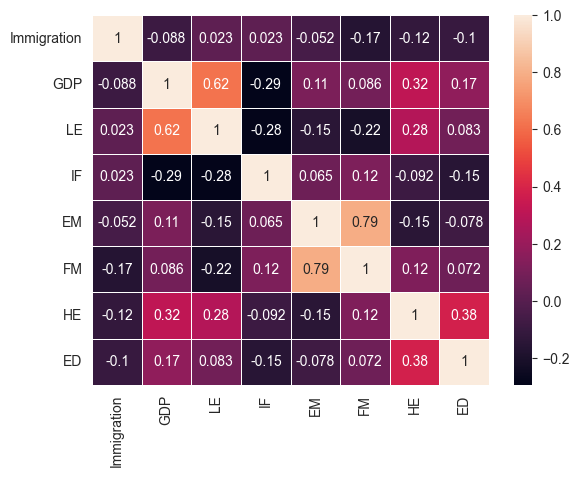

In [79]:
# Generate correlation coefficient heat map.
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

[Text(0.5, 0, 'Government expenditure on education'),
 Text(0, 0.5, 'Country or Region')]

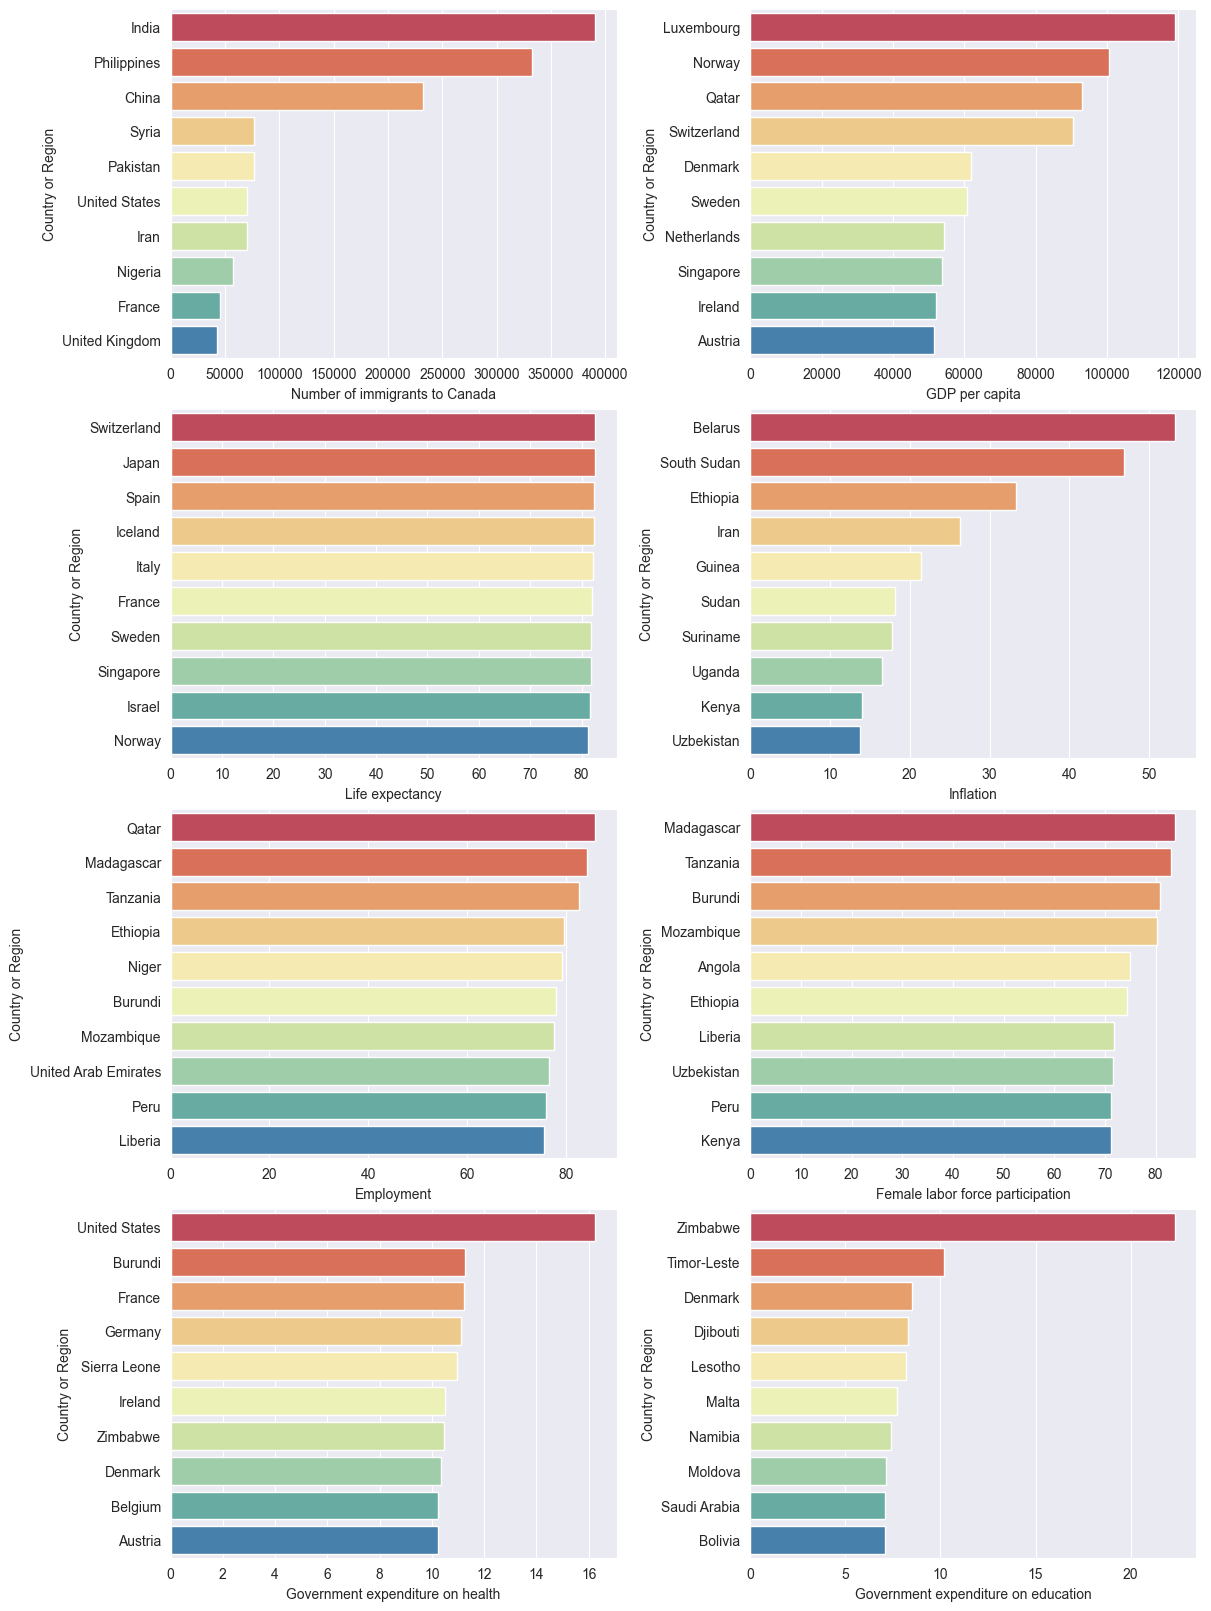

In [80]:
# Display bar graphs for relevant data.
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')

sb.barplot(x='GDP' ,y='Birthplace', data=dataset.nlargest(10, 'GDP'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='GDP per capita', ylabel='Country or Region')

sb.barplot(x='LE',y='Birthplace', data=dataset.nlargest(10, 'LE'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Life expectancy', ylabel='Country or Region')

sb.barplot(x='IF' ,y='Birthplace', data=dataset.nlargest(10, 'IF'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Inflation', ylabel='Country or Region')

sb.barplot(x='EM',y='Birthplace', data=dataset.nlargest(10, 'EM'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Employment', ylabel='Country or Region')

sb.barplot(x='FM',y='Birthplace', data=dataset.nlargest(10, 'FM'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Female labor force participation', ylabel='Country or Region')

sb.barplot(x='HE' ,y='Birthplace', data=dataset.nlargest(10, 'HE'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Government expenditure on health', ylabel='Country or Region')

sb.barplot(x='ED',y='Birthplace', data=dataset.nlargest(10, 'ED'), ax=axes[3,1], palette="Spectral")\
    .set(xlabel='Government expenditure on education', ylabel='Country or Region')

In [81]:
# Visualize the immigration in world map
c = (
    Map()
    .add("", [list(i) for i in zip(dataset['Birthplace'], dataset['Immigration'])], "world")
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="Sources of Immigration to Canada 2011-2021"),
        visualmap_opts=opts.VisualMapOpts(max_=400000))
    .render()
)
os.system("render.html")

0

In [82]:
# Normalize so that the data falls between 0 and 1.

nor = normalize([dataset['Immigration']])
dataset['Immigration'] = nor[0][:]

nor = normalize([dataset['GDP']])
dataset['GDP'] = nor[0][:]

nor = normalize([dataset['LE']])
dataset['LE'] = nor[0][:]

nor = normalize([dataset['IF']])
dataset['IF'] = nor[0][:]

nor = normalize([dataset['EM']])
dataset['EM'] = nor[0][:]

nor = normalize([dataset['FM']])
dataset['FM'] = nor[0][:]

nor = normalize([dataset['HE']])
dataset['HE'] = nor[0][:]

nor = normalize([dataset['ED']])
dataset['ED'] = nor[0][:]

dataset

,Birthplace,Immigration,GDP,LE,IF,EM,FM,HE,ED
0,Afghanistan,0.035563,0.001987,0.072999,0.018953,0.063111,0.025404,0.106563,0.057992
1,Albania,0.009166,0.014179,0.092816,0.029833,0.075797,0.084447,0.057228,0.051593
2,Algeria,0.054295,0.017490,0.088098,0.039361,0.055081,0.023919,0.063631,0.101008
3,Angola,0.000967,0.014415,0.068455,0.117297,0.104691,0.120508,0.033513,0.050755
4,Armenia,0.003533,0.011065,0.087126,0.066555,0.079980,0.089294,0.114841,0.052662
...,...,...,...,...,...,...,...,...,...
136,United States,0.117539,0.159984,0.093469,0.027464,0.083786,0.091827,0.202182,0.109242
137,Uruguay,0.000967,0.045592,0.091498,0.070407,0.090404,0.091553,0.098375,0.072954
138,Uzbekistan,0.003750,0.006554,0.082781,0.119883,0.080521,0.115190,0.064931,0.103786
139,Zambia,0.001408,0.005255,0.068663,0.055936,0.077373,0.083015,0.046249,0.063653


In [83]:
dataset.describe()

,Immigration,GDP,LE,IF,EM,FM,HE,ED
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,0.025773,0.047601,0.083543,0.057926,0.082544,0.080646,0.077966,0.074628
std,0.080460,0.069719,0.010656,0.061347,0.016751,0.024343,0.031950,0.039163
min,0.000017,0.000756,0.055495,-0.003480,0.035119,0.019283,0.023255,0.007812
25%,0.001567,0.004797,0.075289,0.028618,0.072205,0.069978,0.052608,0.051553
50%,0.004950,0.017490,0.086349,0.043306,0.083288,0.084277,0.076059,0.072954
75%,0.014207,0.054026,0.091498,0.068367,0.092215,0.094442,0.102417,0.092821
max,0.651549,0.380341,0.098287,0.463089,0.125706,0.134889,0.202182,0.373916


In [84]:
# By comparing the silhouette coefficients to find the most suitable number of clusters.
def choose_cluster(table):
    score = 0
    n = 0

    for i in range(2, 7):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)

        if sil > score:
            score = sil
            n = i

    print(n, 'clusters, the silhouette score is', score)
    return n

# Perform Kmeans clustering and output the clustering results for each cluster (by country).
def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []

        for k in range(len(a0)):
            if cx[k] == j:
                group.append(a0[k])

        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Immigrants')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.8521795553583277
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

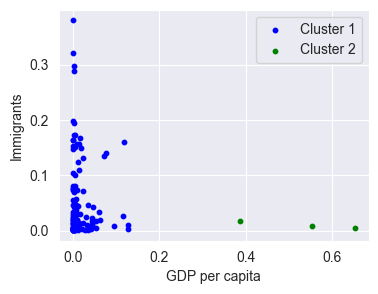

In [85]:
# Clustering using the change in GDP per capita from 2011 to 2021 with the number of immigrants to Canada in this decade.
X1 = pd.DataFrame({'Immigration':dataset['Immigration'], 'GDP':dataset['GDP']}).to_numpy()
plot_cluster(X1, choose_cluster(X1), 'GDP per capita')

2 clusters, the silhouette score is 0.9370043239103841
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

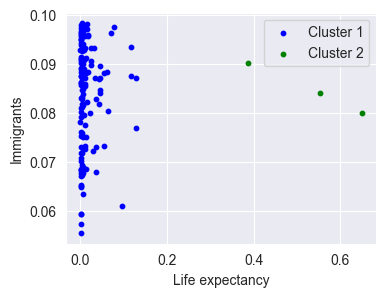

In [86]:
# Clustering using the change in life expectancy from 2011 to 2021 with the number of immigrants to Canada in this decade.
X2 = pd.DataFrame({'Immigration':dataset['Immigration'], 'LE':dataset['LE']}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Life expectancy')

2 clusters, the silhouette score is 0.8773767439168071
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

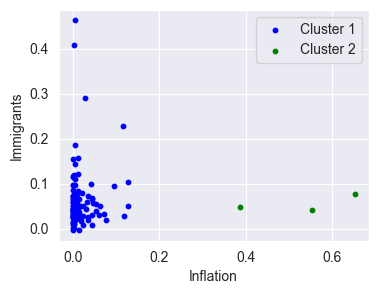

In [87]:
X3 = pd.DataFrame({'Immigration':dataset['Immigration'], 'IF':dataset['IF']}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Inflation')

2 clusters, the silhouette score is 0.9273687404963065
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

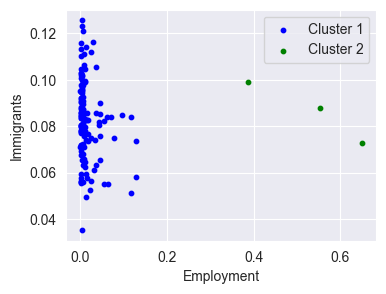

In [88]:
X4 = pd.DataFrame({'Immigration':dataset['Immigration'], 'EM':dataset['EM']}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Employment')

2 clusters, the silhouette score is 0.9162731156842683
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

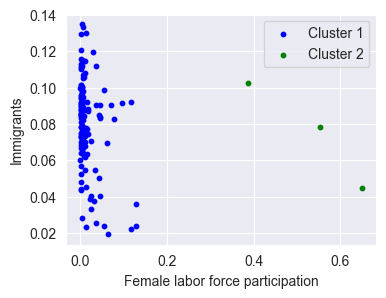

In [89]:
X5 = pd.DataFrame({'Immigration':dataset['Immigration'], 'FM':dataset['FM']}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Female labor force participation')

2 clusters, the silhouette score is 0.9007448301699935
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

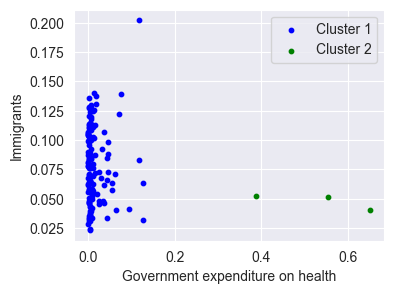

In [90]:
X6 = pd.DataFrame({'Immigration':dataset['Immigration'], 'HE':dataset['HE']}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Government expenditure on health')

2 clusters, the silhouette score is 0.8971268485192875
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

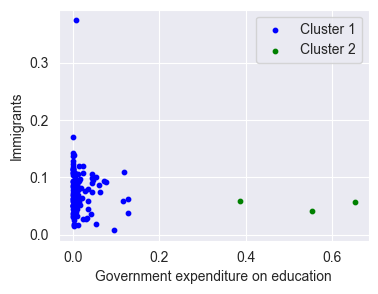

In [91]:
X7 = pd.DataFrame({'Immigration':dataset['Immigration'], 'ED':dataset['ED']}).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'Government expenditure on education')

4 clusters, the silhouette score is 0.46171616070813853
Cluster 1: ['Austria', 'Belgium', 'Brunei Darussalam', 'Cyprus', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Luxembourg', 'Netherlands', 'Norway', 'Qatar', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates', 'United Kingdom', 'United States']
Cluster 2: ['Belarus', 'Ethiopia', 'Guinea', 'Iran', 'South Sudan']
Cluster 3: ['China', 'India', 'Philippines']
Cluster 4: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Czechia', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Gabon', 'Georgia', 'Ghana', 'Greece', 'Guatemala', 'Guinea-Bi

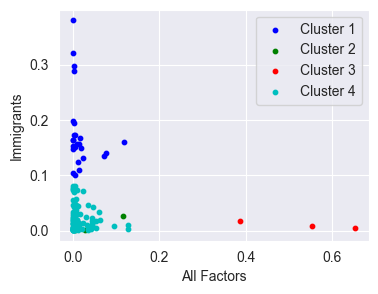

In [92]:
# Clustering with all other indicators using immigrants data.
X8 = dataset.drop(['Birthplace'], axis=1).to_numpy()
plot_cluster(X8, choose_cluster(X8), 'All Factors')

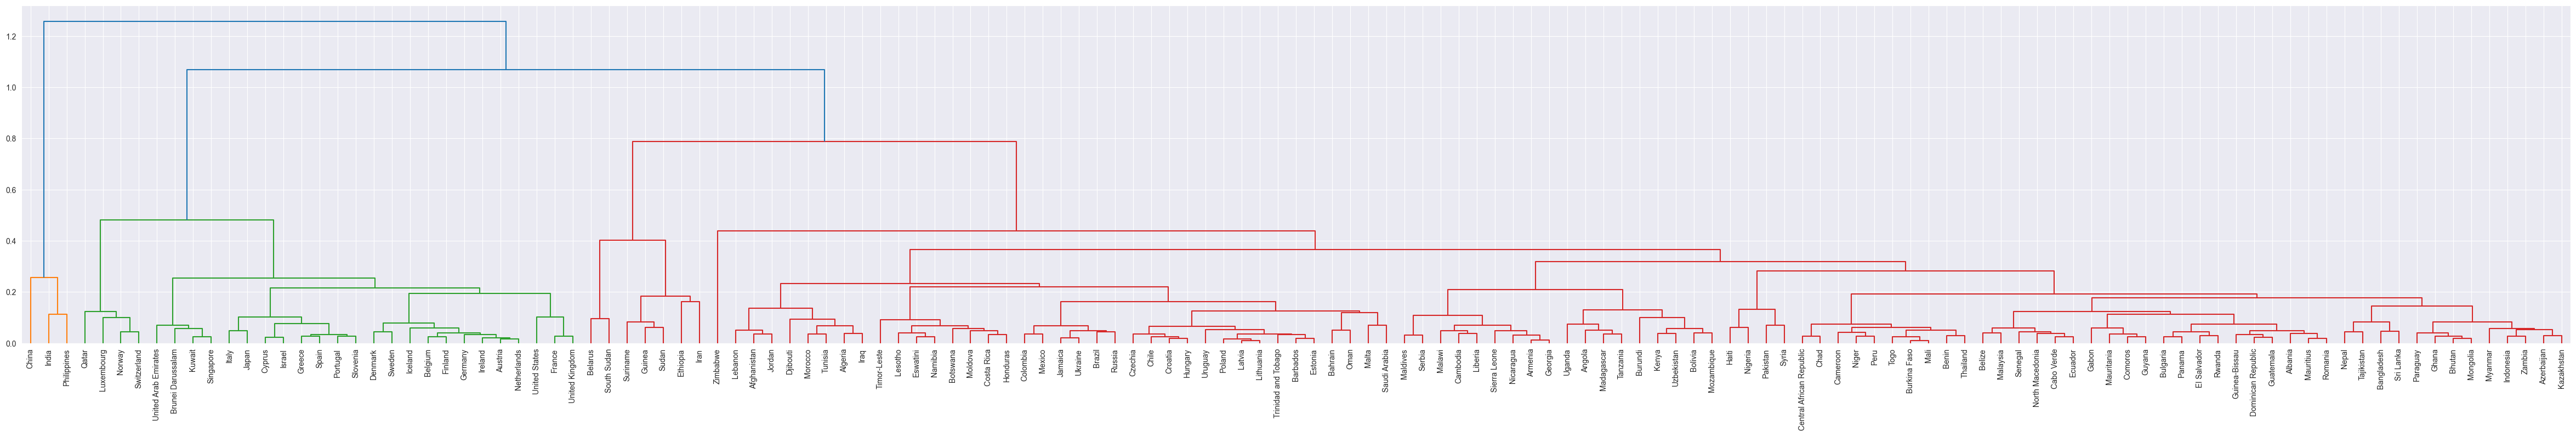

In [93]:
# Hierarchical clustering using the entire dataset.
comb_data = dataset.drop(['Birthplace'], axis=1)
plt.figure(figsize=(60, 8))
dend=sch.dendrogram(sch.linkage(comb_data,method='ward'), labels=a0, leaf_font_size=10)

### End of Experiments.